In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
from scipy import sparse
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)
import sys
import pickle
import copy
from glob import glob
from importlib import reload

sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import community
import fieldsetter_cmems
import advectParticles

Stripy is not available on this machine.


In [2]:
reload(plot)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/science/users/4302001/arctic-connectivity/tools/advectParticles.py'>

In [3]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
meanDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"
matdir = "/data/oceanparcels/output_data/data_Daan/matrices/"
netdir = "/data/oceanparcels/output_data/data_Daan/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/communities/"

In [4]:
fieldset = fieldsetter_cmems.create(20010101, 1, antiBeach=False)

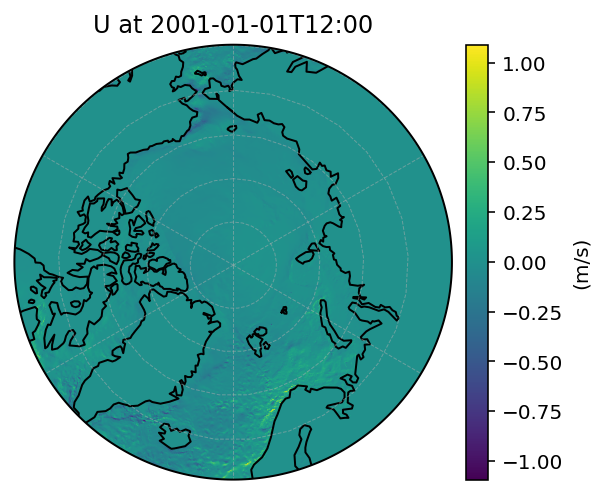

In [5]:
fig, ax = plot.from_field(fieldset.U, polar=True, land=False, latRange=(60,90))
plt.show()

In [6]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBins = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMask = community.hexMask(myBins, -180, 180, 60, 90)
myMask.growToLevel(4)
myBins.calculate_voronoi(myMask, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBins.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBins.oceanMask = pickle.load(pickFile)

In [7]:
myParts = community.particles.from_pickle('/scratch/DaanR/meshes/ico_mesh_parts_deg_arctic_r11_delland.pickle')
print("Number of particles:", myParts.n)

Number of particles: 1450665


In [10]:
# myBins.oceanMask_from_particles(myParts, fieldset=fieldset)
# with open("oceanMask_no_rim.pickle", "wb") as pickFile:
#     pickle.dump(myBins.oceanMask, pickFile)

In [8]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.initCount[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             units = "number of particles",
                                             size=(8,8))

AttributeError: 'hexCountBins' object has no attribute 'initCount'

## March 2018

In [8]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"

In [ ]:
transMat_20180301 = community.transMat.from_pset(psetdir + f"pset_{runName}.nc", 
                                               myBins, 
                                               timedelta64 = np.timedelta64(30, 'D'),
                                               mask = myBins.oceanMask)
transMat_20180301.save_counter(matdir + f"masked_counter_{runName}_Cico7_subD30")
transMat_20180301.save_network(netdir + f"masked_network_{runName}_Cico7_subD30.net")

In [9]:
transMat_20180301 = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7_subD30.npz")

In [10]:
G = transMat_20180301.to_network()

In [12]:
G.selfloop_edges()

<generator object selfloop_edges.<locals>.<genexpr> at 0x7fe234e3bb88>

In [11]:
comName = runName + "_Cico7_subD30_mt2"

In [12]:
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.8023344518411846
Global Mixing Parameter 0.32470413701587175


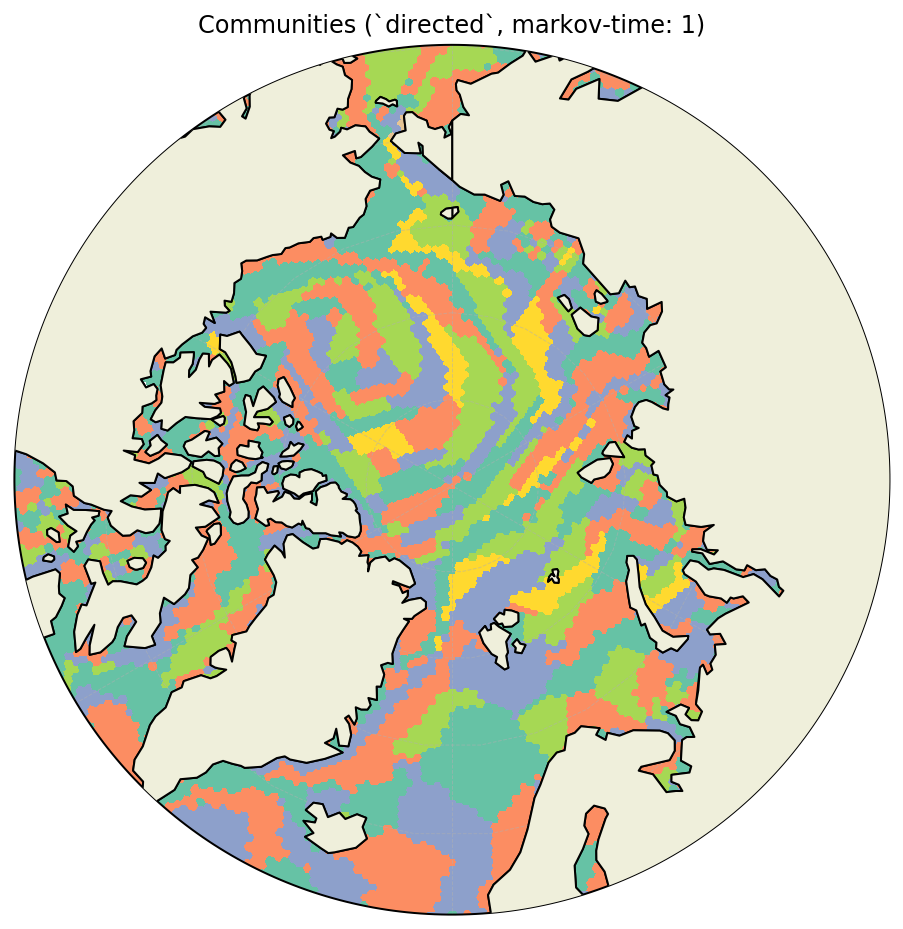

In [34]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (`directed`, markov-time: 1)"
                                            )

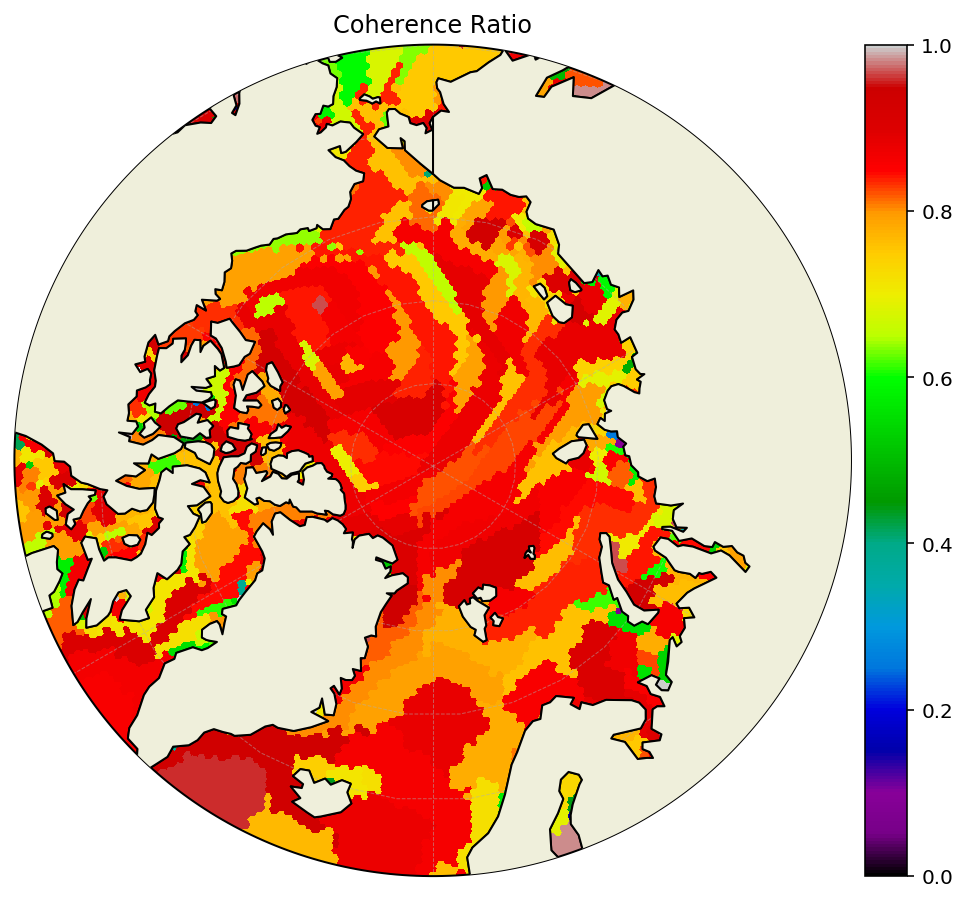

In [40]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.coherenceRatio[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"coherence_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Coherence Ratio"
                                            )

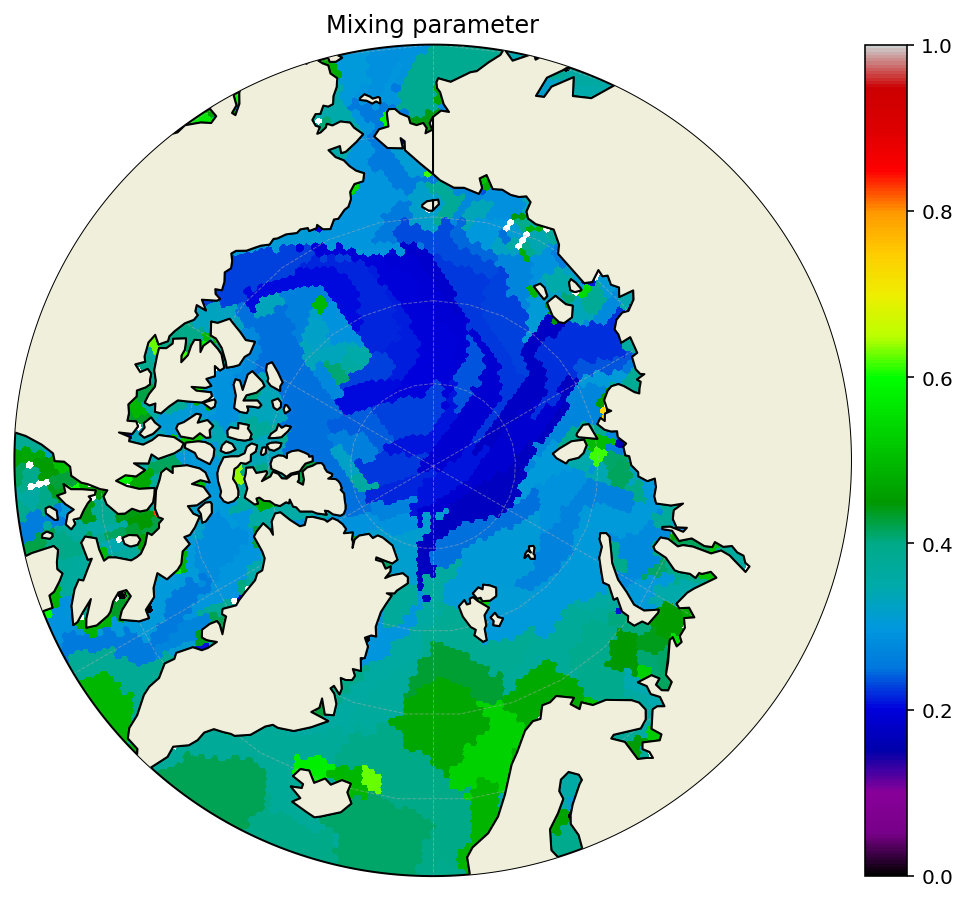

In [41]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.mixing[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"mixing_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Mixing parameter"
                                            )

## September 2018

In [6]:
runName = "Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24"

In [24]:
runName = "Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24"
transMat_20180901 = community.transMat.from_pset(psetdir + f"pset_{runName}.nc", 
                                               myBins, 
                                               timedelta64 = np.timedelta64(30, 'D'),
                                               mask = myBins.oceanMask)
transMat_20180901.save_counter(matdir + f"masked_counter_{runName}_Cico7_subD30")
transMat_20180901.save_network(netdir + f"masked_network_{runName}_Cico7_subD30.net")

 Determining particle bins. 100%

In [7]:
transMat_20180901 = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7_subD30.npz")

In [17]:
runName = "Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24"
comName = runName + "_Cico7_subD30_mt2"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180901);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180901);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.8111025115414452
Global Mixing Parameter 0.3529999035171672


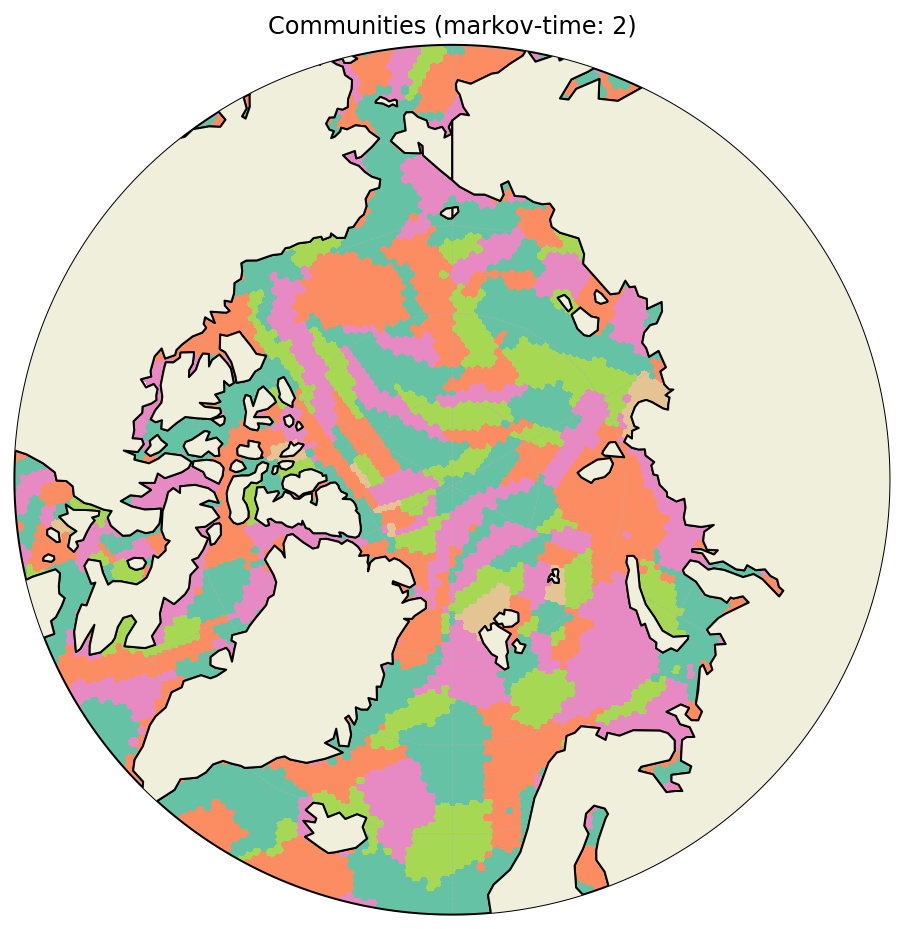

In [32]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (markov-time: 2)"
                                            )

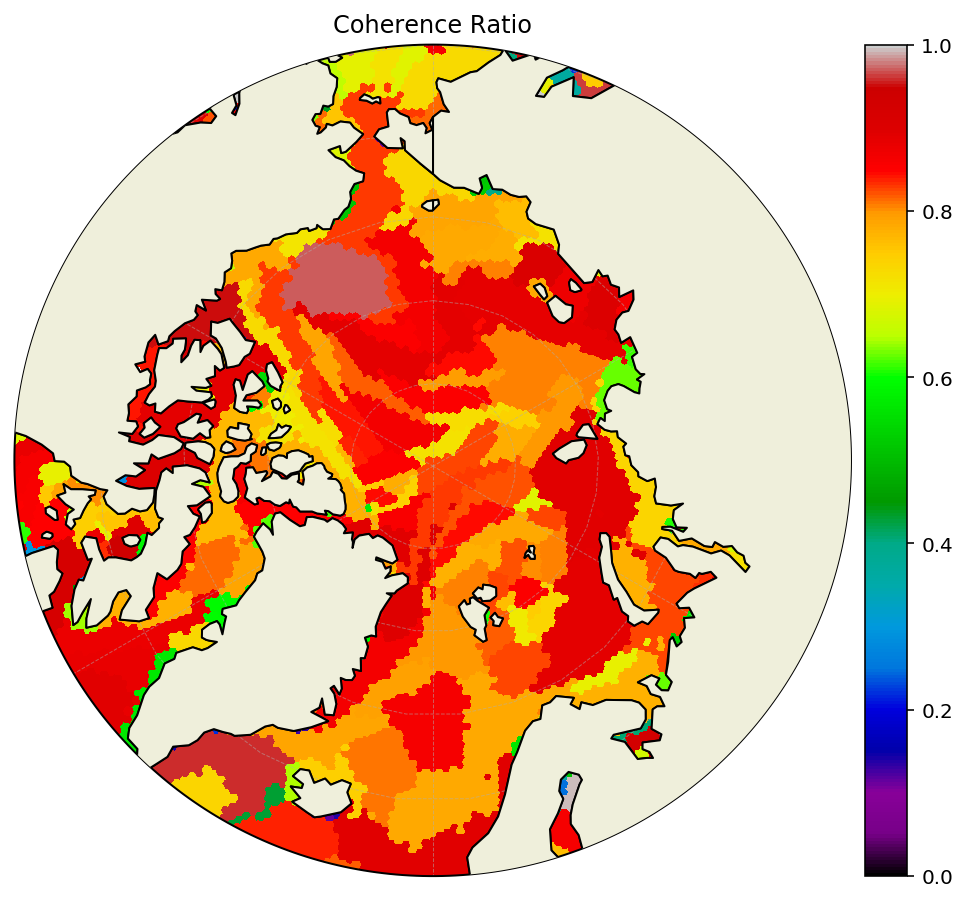

In [43]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.coherenceRatio[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"coherence_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Coherence Ratio"
                                            )

# Sea ice

In [8]:
ice_ds = xr.open_dataset(meanDir + "mercatorglorys12v1_gl12_mean_201809.nc")

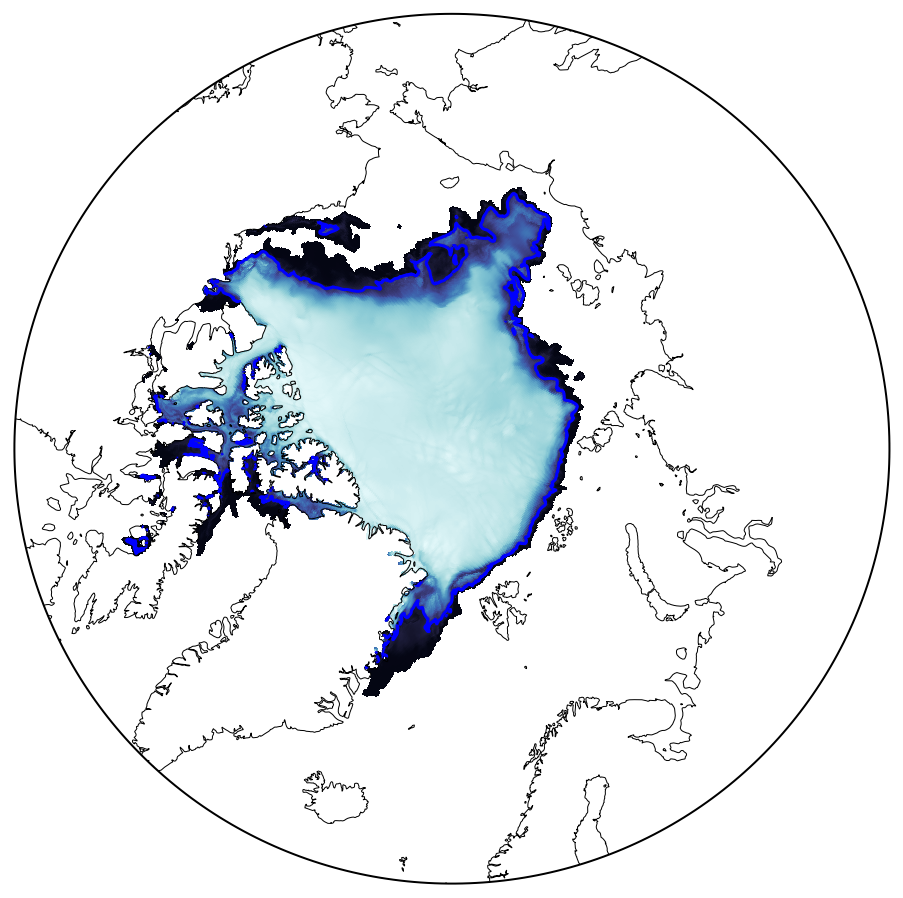

In [9]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent((-180, 180, 60, 90), crs=ccrs.PlateCarree())
circle_clip = plot.set_circular_boundary(ax)
ax.coastlines(resolution='50m', linewidth=0.5)
ax.pcolormesh(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], cmap=cmocean.cm.ice, transform=ccrs.PlateCarree())
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='blue', transform=ccrs.PlateCarree())

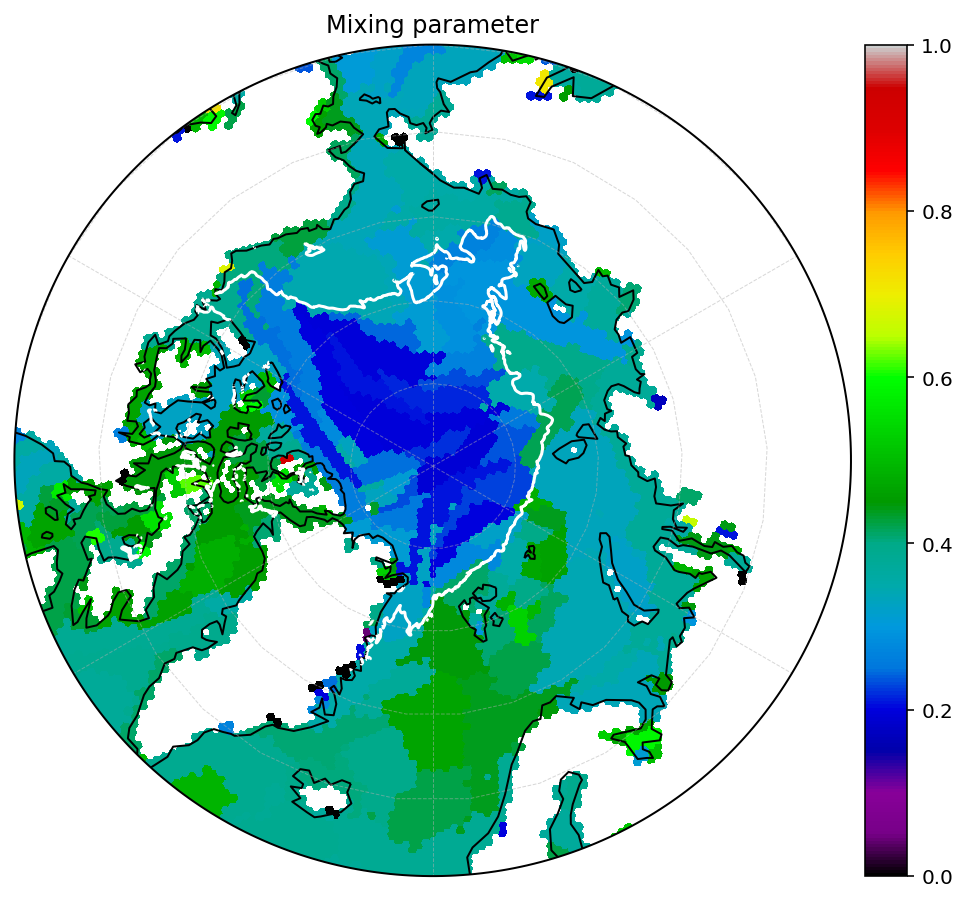

In [46]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.mixing[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = False,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"mixing_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Mixing parameter"
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())

In [144]:
ice_ds.siconc[0,1680:, :]

<xarray.DataArray 'siconc' (latitude: 361, longitude: 4320)>
[1559520 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.91667 ... 179.83333 179.91667
  * latitude   (latitude) float32 60.0 60.083332 60.166668 ... 89.916664 90.0
    time       datetime64[ns] 2018-09-15T12:00:00
Attributes:
    long_name:      Ice concentration
    standard_name:  sea_ice_area_fraction
    units:          1
    unit_long:      Fraction
    valid_min:      1
    valid_max:      29030
    cell_methods:   area: mean where sea_ice

In [10]:
meshlon, meshlat= np.meshgrid(ice_ds.longitude, ice_ds.latitude[1680:])
dataPoints = np.dstack((meshlon.flatten(), meshlat.flatten()))[0]
dataVals = np.where(np.isnan(ice_ds.siconc[0,1680:, :].data.flatten()), 0, ice_ds.siconc[0,1680:, :].data.flatten())
binPoints = np.dstack((myBins.lons[myMask[3]], myBins.lats[myMask[3]]))[0]
interpolatedIce = griddata(dataPoints, dataVals, binPoints, method="nearest")

In [55]:
def pointToIdx(qlon, qlat, hexBins):
    lons = hexBins.lons[hexBins.mask[hexBins.outerMaskLevel]]
    lats = hexBins.lats[hexBins.mask[hexBins.outerMaskLevel]]
    binPoints = np.dstack((lons, lats))[0]
    return griddata(binPoints, hexBins.bindex, np.dstack((qlon, qlat))[0], method="nearest")

In [56]:
pointToIdx(0, 85, myBins)

array([3061])

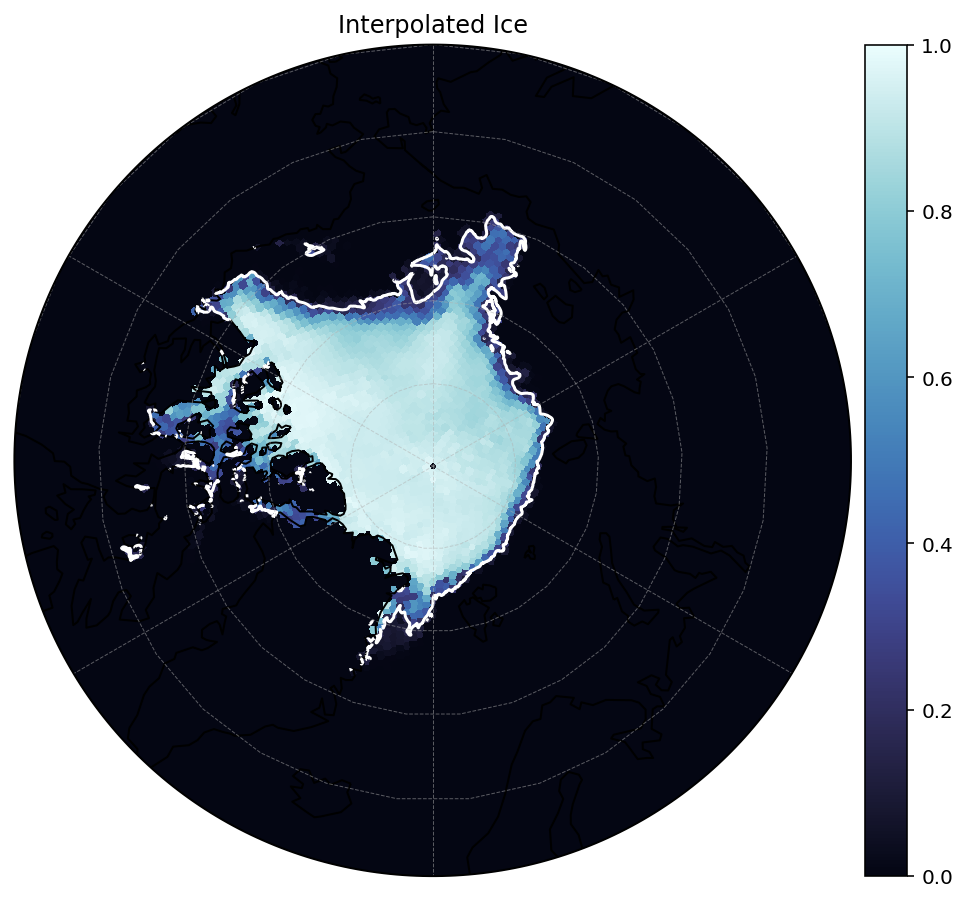

In [11]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             interpolatedIce[myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = False,
                                            colormap = cmocean.cm.ice,
                                            size = (8,8),
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Interpolated Ice"
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())

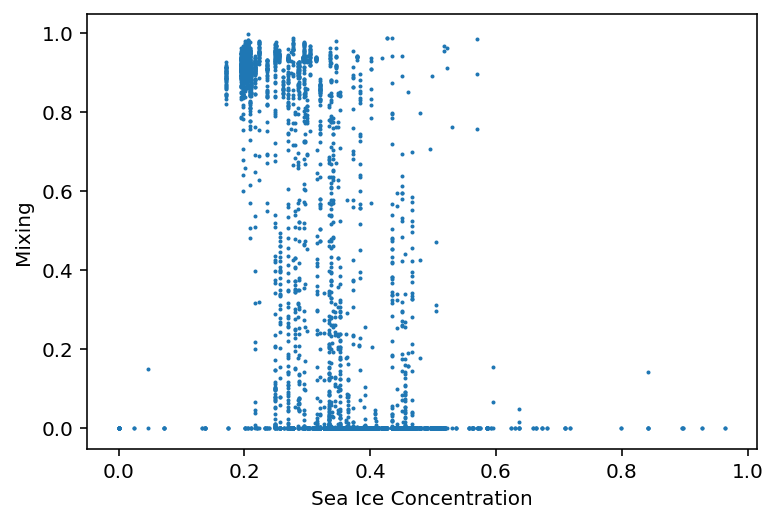

,mixing,SIC
mixing,1.000000,-0.595734
SIC,-0.595734,1.000000


In [68]:
# Quick-and-dirty correlation of SIC and mixing in individual hexbins
mixingIceDF = pd.DataFrame(myBins.mixing[myBins.oceanMask], index=myBins.bindex[myBins.oceanMask], columns=["mixing"])
mixingIceDF['SIC'] = interpolatedIce[myBins.oceanMask]
plt.scatter(myBins.mixing[myBins.oceanMask], 
            interpolatedIce[myBins.oceanMask], s=1)
plt.xlabel('Sea Ice Concentration')
plt.ylabel('Mixing')
plt.show()
mixingIceDF.corr()

In [72]:
# Better approach by averaging SIC in each community and correlating values accros whole communities
avg_sea_ice_per_community = {}
assert myBins.lons[myMask[3]].shape == myBins.bindex.shape
for community in myBins.communityIdx.keys():
    vals = interpolatedIce[myBins.communityIdx[community]['bindex']]
    avg_sea_ice_per_community[community] = np.mean(vals[~np.isnan(vals)])
    
communityIce = np.ma.zeros(myBins.bindex.shape)
for i in myBins.bindex:
    try:
        communityIce[i] = avg_sea_ice_per_community[myBins.communityID.data[i]]
    except KeyError:
        pass
communityIce.mask = myBins.communityID.mask

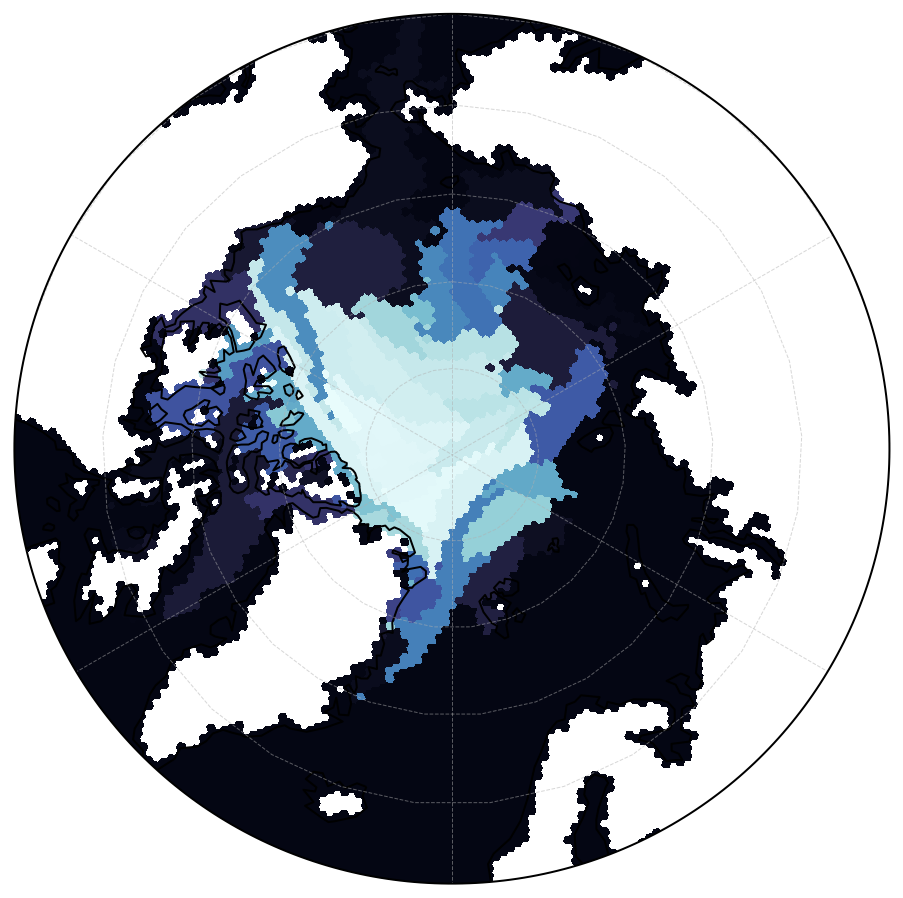

In [59]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             communityIce[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = False,
                                             colormap = cmocean.cm.ice,
                                             size = (8,8),
                                             cbar=False,
                                             polar = True,
                                            )

Text(0, 0.5, 'Mixing')

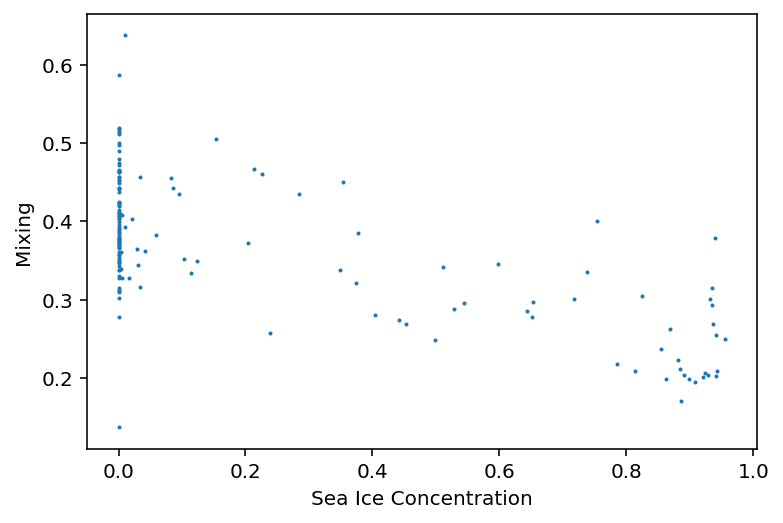

In [73]:
communityName, commOccurance = np.unique(myBins.communityID, return_counts=True)
communityStats = pd.DataFrame(commOccurance, index=communityName, columns=["numCells"])
communityStats.drop(-1)
communityStats = communityStats.join(pd.DataFrame.from_dict(avg_sea_ice_per_community, orient='index', columns=['sea_ice']))
communityStats = communityStats.join(pd.DataFrame.from_dict(myBins.mixingDict, orient="index", columns=["mixing"]))
communityStats.replace(to_replace=-1, value=np.NaN, inplace=True)
significantCommunity = communityStats['numCells'] > 5
plt.scatter(communityStats[significantCommunity].dropna()['sea_ice'], 
            communityStats[significantCommunity].dropna()['mixing'], s=1)
plt.xlabel("Sea Ice Concentration")
plt.ylabel("Mixing")

In [78]:
communityStats[significantCommunity].corr()

,numCells,sea_ice,mixing
numCells,1.000000,-0.045785,-0.179541
sea_ice,-0.045785,1.000000,-0.679692
mixing,-0.179541,-0.679692,1.000000


## 2017: Persistence and sea ice correlations

In [ ]:
for i in range(2010, 2016):
    runName = f"Rcmems_Pico11_S{i}-3-1_D90_DT20_ODT24"
    transMat = community.transMat.from_pset(psetdir + f"pset_{runName}.nc", 
                                                   myBins, 
                                                   timedelta64 = np.timedelta64(30, 'D'),
                                                   mask = myBins.oceanMask)
    transMat.save_counter(matdir + f"masked_counter_{runName}_Cico7_subD30")
    transMat.save_network(netdir + f"masked_network_{runName}_Cico7_subD30.net")